In [76]:
import sys
sys.path.append('../vysxd')
from vysxd_analysis import *
from vysxd_define import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as manimation
from scipy import *

In [3]:
def density_transform(v: float, t: float, x: np.array):
    gamma = 1/np.sqrt(1-v**2)

    t1 = np.zeros(len(x))+t
    x1 = x

    t2 = gamma*(t1 - v*x1)
    x2 = gamma*(x1 - v*t1)
    return t2,x2

In [4]:
p1x1_files = np.sort(os.listdir('data/MS/PHA/p1x1/electrons/')) # Create a sorted list of filenames you will be analyzing
p1x1_temp = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{p1x1_files[0]}') # pick out the first timestep for reasons
time_prime, x_prime = density_transform(v=0.10,t=p1x1_temp.TIME[0],x=p1x1_temp.X)
density = -np.trapz(p1x1_temp.DATA, axis=0)

for file in p1x1_files[1:]:
    p1x1 = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{file}') # Pull the phase space data
    time_prime_temp, x_prime_temp = density_transform(v=0.10,t=p1x1.TIME[0],x=p1x1.X)
    density_temp = -np.trapz(p1x1.DATA, axis=0)

    time_prime = np.vstack((time_prime, time_prime_temp))
    x_prime = np.vstack((x_prime, x_prime_temp))
    density = np.vstack((density, density_temp))

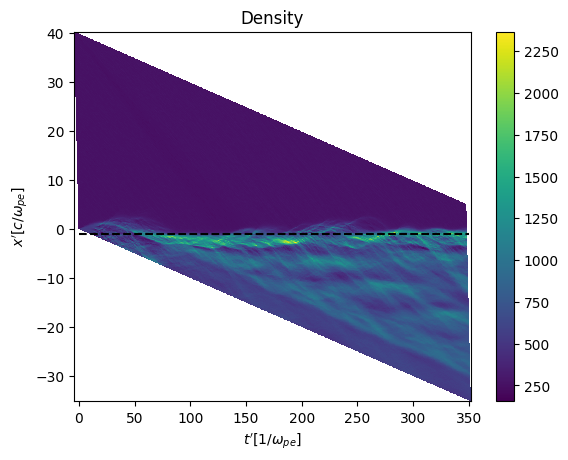

In [5]:
d_min, d_max = np.abs(density).min(), np.abs(density).max()

c = plt.pcolormesh(time_prime,x_prime, density, vmin = d_min, vmax = d_max)
plt.colorbar(c)
plt.ylabel(r'$x^\prime [c/\omega_{pe}]$')
plt.xlabel(r'$t^\prime [1/\omega_{pe}]$')
plt.hlines(-1.0,0,350, colors = 'black', linestyles= '--')
plt.title('Density')
plt.show()

In [72]:
# Integrate over what is constant position in the transformed frame

def line_integrate(q_f: list, t0: float, t1: float, x0: float, v: float):


    # Integrate along a line with slope v, starting at some specified x position, and then normalize by that time interval 
    soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)

    # scipy.integrate returns the result and the error of numerical integration
    return soln[0], soln[1]

def box_integrate(q: list, xmin, xmax, tmin, tmax, v, plot_flag = True, q_0 = None) -> np.array:
    t_axis = q[3]
    x_axis = q[4]

    # It is necessary to interpolate your quantity in order to integrate along this path without too much headache
    q_f = interpolate.RegularGridInterpolator([t_axis,x_axis], q[0])
    dx = q[2]

    xmin_index = int(xmin/dx)
    xmax_index = int(xmax/dx)

    # Perform line integrations for successive x values in desired box
    solution = []
    for x in x_axis[xmin_index:xmax_index]: 
        solution.append(line_integrate(q_f, tmin, tmax, x, v)[0])

    # Immediately show a plot to verify, if desired
    if plot_flag: 
        plt.plot(x_axis[xmin_index:xmax_index], solution)
        if q_0 != None:
            plt.xlabel(f'{q_0.AXIS1_NAME} [${q_0.AXIS1_UNITS}$]')
            plt.ylabel(f'integrated {q_0.DATA_NAME} density')
            plt.title(f'integrated along lines of v = {v}')
            plt.legend()

    return np.array(solution)

def illustrate_box(q: list, xmin, xmax, tmin, tmax, v, q_0 = None) -> None:
    fig, ax = plt.subplots()
    # Make a heatmap of quantity in t,x space (sorry Paulo)
    plt.imshow(np.transpose(q[0]), origin='lower', extent=[q[3][0], q[3][-1], q[4][0], q[4][-1]], aspect='auto')

    # If vysxd.get_data timeshot is supplied, use this to label axes
    if (q_0 != None):
        plt.ylabel(f"{q_0.AXIS1_NAME}' [${q_0.AXIS1_UNITS}$]")
        plt.xlabel(f"Time [${q_0.TIME_UNITS}'$]")
        plt.colorbar(label=q_0.DATA_NAME)

    # Draw a parallelogram to illustrate entire region that is being integrated
    vertices = [[tmin,xmin],[tmin,xmax],[tmax,xmax+v*(tmax-tmin)],[tmax,xmin+v*(tmax-tmin)]]
    box = patches.Polygon(vertices, ls = '--', fill =False, color = 'red')
    ax.add_patch(box)

    # Draw arrows to illustrate which lines are being integrated over
    arrow = patches.Arrow(tmin,xmax,tmax-tmin,v*(tmax-tmin), color = 'red',width=1, ls = '--')
    ax.add_patch(arrow)
    arrow = patches.Arrow(tmin,xmin,tmax-tmin,v*(tmax-tmin), color = 'red',width=1, ls = '--')
    ax.add_patch(arrow)
    arrow = patches.Arrow(tmin,(xmax+xmin)/2,tmax-tmin,v*(tmax-tmin), color = 'red',width=1, ls = '--')
    ax.add_patch(arrow)
    
    # Need to expand limits of ax or drawings will be cut off
    ax.set_ylim(q[4][0],q[4][-1])
    ax.set_xlim(q[3][0],q[3][-1])
    plt.show()

In [80]:
## pull data

b1_path = 'data/MS/FLD/part_b1/'
b2_path = 'data/MS/FLD/part_b2/'
b3_path = 'data/MS/FLD/part_b3/'

b1= get_osiris_quantity_1d(b1_path)
b1_0 = vysxd_get_data(f'{b1_path}part_b1-000000.h5') ##can use this for easy labeling

b2 = get_osiris_quantity_1d(b2_path)
b2_0 = vysxd_get_data(f'{b2_path}part_b2-000000.h5')

b3 = get_osiris_quantity_1d(b3_path)
b3_0 = vysxd_get_data(f'{b3_path}part_b3-000000.h5')


e1_path = 'data/MS/FLD/part_e1/'
e2_path = 'data/MS/FLD/part_e2/'
e3_path = 'data/MS/FLD/part_e3/'

e1 = get_osiris_quantity_1d(e1_path)
e1_0 = vysxd_get_data(f'{e1_path}part_e1-000000.h5') ##can use this for easy labeling

e2 = get_osiris_quantity_1d(e2_path)
e2_0 = vysxd_get_data(f'{e2_path}part_e2-000000.h5')

e3 = get_osiris_quantity_1d(e3_path)
e3_0 = vysxd_get_data(f'{e3_path}part_e3-000000.h5')

e_density = get_osiris_quantity_1d('data/MS/DENSITY/electrons/charge/')
e_density_0 = vysxd_get_data('data/MS/DENSITY/electrons/charge/charge-electrons-000000.h5')

p_density = get_osiris_quantity_1d('data/MS/DENSITY/positrons/charge/')
p_density_0 = vysxd_get_data('data/MS/DENSITY/positrons/charge/charge-positrons-000000.h5')

e_ufl = get_osiris_quantity_1d('data/MS/UDIST/electrons/ufl1/')
e_ufl_0 = vysxd_get_data('data/MS/UDIST/electrons/ufl1/ufl1-electrons-000000.h5')

/tmp/ipykernel_5006/1808754956.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)


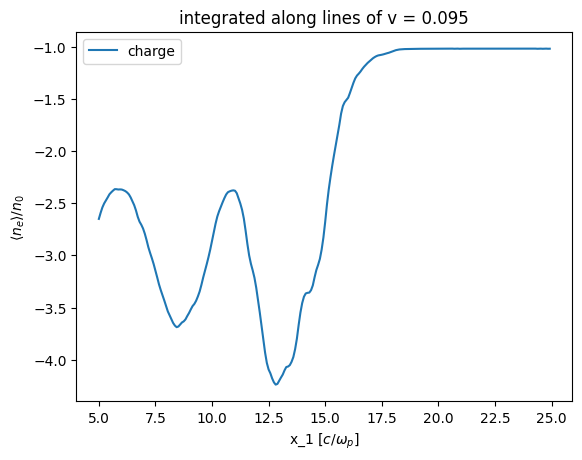

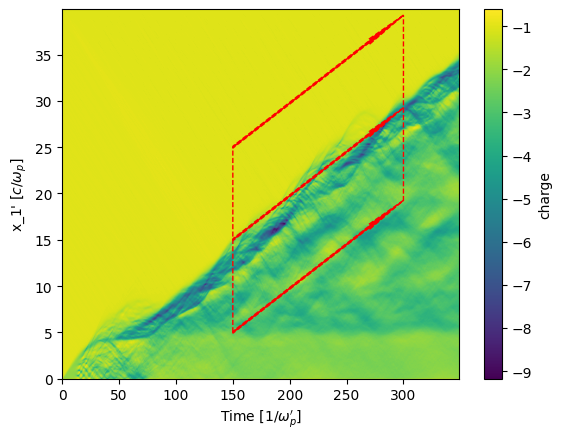

In [97]:
xmin = 5; xmax = 25; tmin = 150;tmax =300; v=.095

electron_density_integrated = box_integrate(q=e_density,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=e_density_0, plot_flag=True)
# plt.plot(e_density[4], e_density[0][100])
# positron_density_integrated = box_integrate(q=p_density,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=p_density_0, plot_flag=True)
plt.ylabel(r'$\langle n_e \rangle /n_0$')

illustrate_box(q=density,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax, v= v, q_0 = e_density_0)

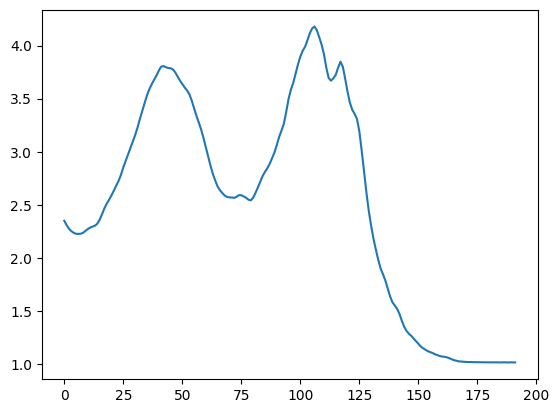

In [59]:
plt.plot(-1*electron_density_integrated+positron_density_integrated)

$\langle n_e \rangle$

/tmp/ipykernel_5006/1808754956.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)


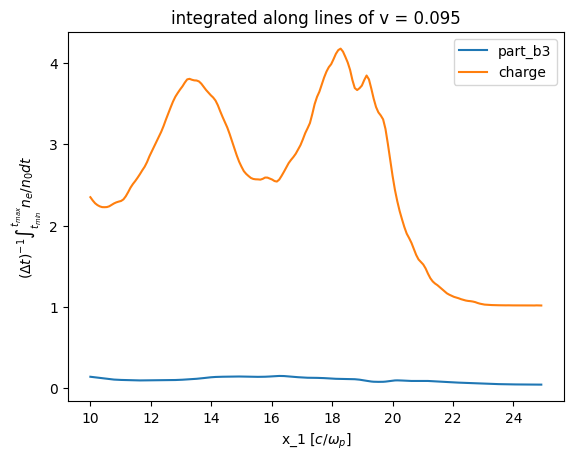

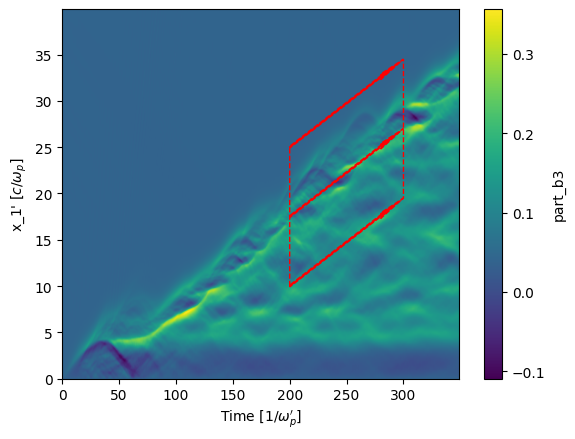

In [74]:
b3_integrated = box_integrate(q=b3,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=b3_0)
positron_density_integrated = box_integrate(q=p_density,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=p_density_0, plot_flag=True)
# plt.legend()
plt.ylabel('$(\Delta t)^{-1}\int_{t_{min}}^{t_{max}} n_e/n_0 dt$')

illustrate_box(q=b3,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax, v= v, q_0 = b3_0)

/tmp/ipykernel_5006/1808754956.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)
/tmp/ipykernel_5006/1808754956.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  soln = integrate.quad(lambda t: 1/(t1-t0)*q_f([t, v*(t-t0)+x0]),t0,t1)


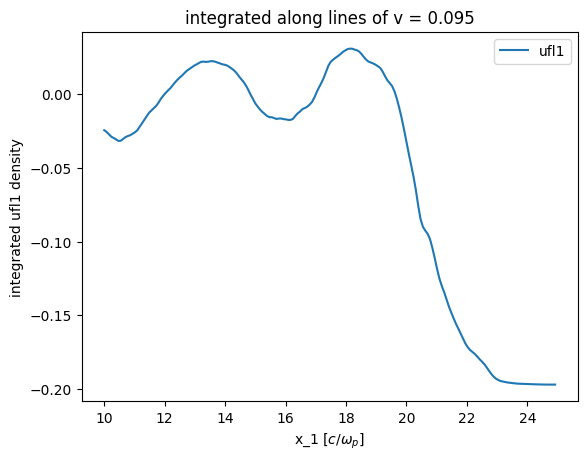

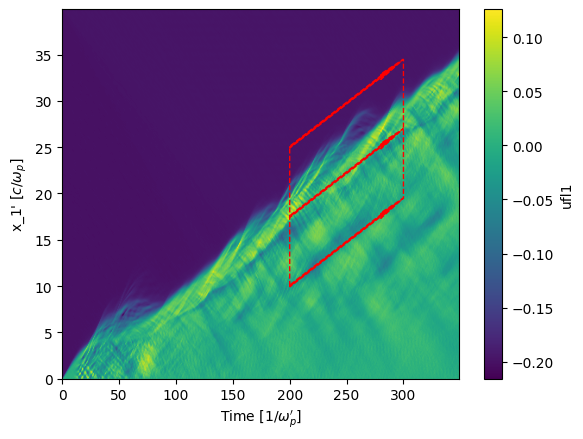

In [81]:
e_ufl_integrated = box_integrate(q=e_ufl,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=e_ufl_0)

illustrate_box(q=e_ufl,xmin=xmin,xmax=xmax,tmin=tmin,tmax=tmax,v = v, q_0=e_ufl_0)

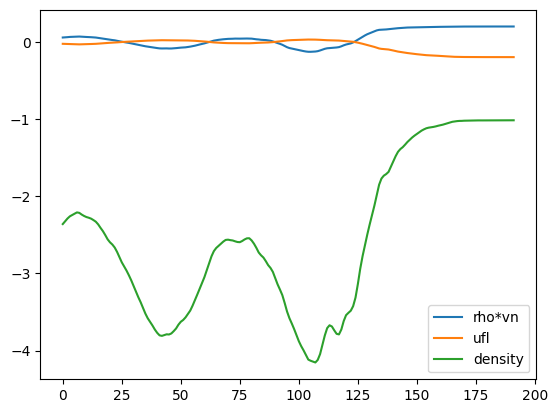

In [90]:
plt.plot(e_ufl_integrated*electron_density_integrated, label = "rho*vn")
plt.plot(e_ufl_integrated, label = 'ufl')
plt.plot(electron_density_integrated, label = 'density')
plt.legend()